# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [108]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
from sklearn.externals import joblib
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    nucleus=xscaler.transform(np.array([[Z,N]]))
    [[BE]] = yscaler.inverse_transform(model.predict(nucleus,verbose=0))
    return BE

def GenerateMasses():
    
    nuclei=[[0,0]]
    for zi in range(1,120):
        for ni in range(0,160):
            nuclei=np.append(nuclei,xscaler.transform([[zi,ni]]),axis=0)
            
    energies=yscaler.inverse_transform(model.predict(nuclei,verbose=0))
    nuclei = xscaler.inverse_transform(nuclei)
    a_sum=np.sum(nuclei,axis=1)
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':energies[:,0]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

# And now to load scaler

xscaler = joblib.load(xscaler_filename)     
yscaler = joblib.load(yscaler_filename)     
 
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses_testing.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

500/500 [==============================] - 0s 75us/sample - loss: 5.4648e-07 - R2: 1.0000


/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Test Loss: 5.465e-07
Test R2: 1.0


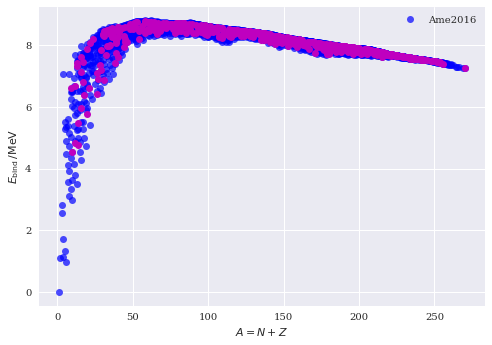

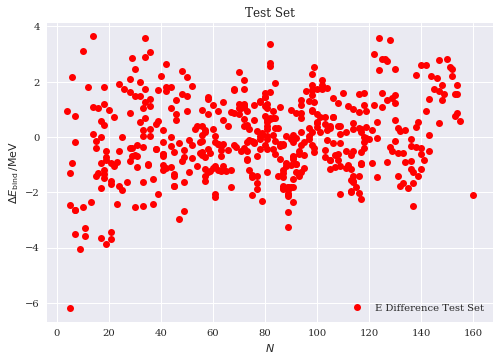

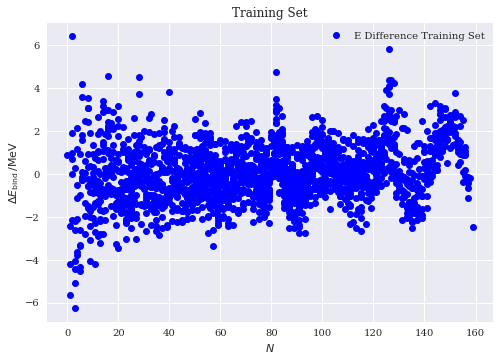

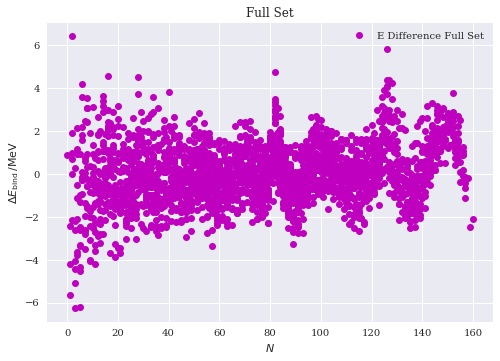

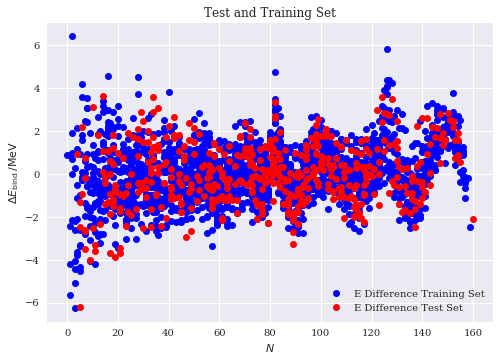

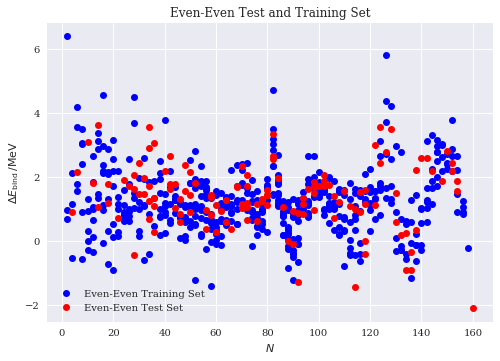

In [99]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (np.asarray(Energies)*aa).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

#xscaler = MinMaxScaler()
#xscaler.fit(x_train)

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

#yscaler = MinMaxScaler()
#yscaler.fit(y_train)

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out/a_test,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'ro',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train_even[:,1], traindiff_even,'ro',label='Even-Even Training Set',c='b')
ax.plot(x_test_even[:,1], diff_even,'ro',label='Even-Even Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Even-Even Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("eveneven")
plt.show()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [66]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [97]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE/A)
    print("Total Binding Energy:",pBE)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (np.asarray(Energies)*aa).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xscaler_filename = "xscaler.save"

xscaler = MinMaxScaler()
xscaler.fit(x_train)

joblib.dump(xscaler, xscaler_filename) 

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler_filename = "yscaler.save"

yscaler = RobustScaler()
yscaler.fit(y_train)

joblib.dump(yscaler, yscaler_filename) 

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.000001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=10000, batch_size=8, validation_split=0.2,verbose=1)
history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out/a_test,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'ro',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 1597 samples, validate on 400 samples
Epoch 1/10000
1597/1597 [==============================] - 3s 2ms/sample - loss: 0.4513 - R2: -0.2785 - val_loss: 0.4134 - val_R2: -0.2138
Epoch 2/10000
1597/1597 [==============================] - 1s 590us/sample - loss: 0.4498 - R2: -0.2504 - val_loss: 0.4117 - val_R2: -0.1177
Epoch 3/10000
1597/1597 [==============================] - 1s 590us/sample - loss: 0.4482 - R2: -0.2808 - val_loss: 0.4101 - val_R2: -0.2576
Epoch 4/10000
1597/1597 [==============================] - 1s 591us/sample - loss: 0.4468 - R2: -0.2425 - val_loss: 0.4085 - val_R2: -0.4349
Epoch 5/10000
1597/1597 [==============================] - 1s 584us/sample - loss: 0.4453 - R2: -0.2058 - val_loss: 0.4069 - val_R2: -0.1674
Epoch 6/10000
1597/1597 [==============================] - 1s 583us/sample - loss: 0.4438 - R2: -0.2006 - val_loss: 0.4053 - val_R2: -0.1907
Epoch 7/10000
1597/1597 [==============================] - 1s 563us/sample - loss: 0.4423 - R2: -0.2809 - val

1597/1597 [==============================] - 1s 556us/sample - loss: 0.3790 - R2: -0.0082 - val_loss: 0.3385 - val_R2: -0.0308
Epoch 59/10000
1597/1597 [==============================] - 1s 565us/sample - loss: 0.3778 - R2: -0.0153 - val_loss: 0.3374 - val_R2: -0.0053
Epoch 60/10000
1597/1597 [==============================] - 1s 574us/sample - loss: 0.3766 - R2: 0.0068 - val_loss: 0.3362 - val_R2: -0.0447
Epoch 61/10000
1597/1597 [==============================] - 1s 574us/sample - loss: 0.3754 - R2: -4.3251e-04 - val_loss: 0.3349 - val_R2: 0.0507
Epoch 62/10000
1597/1597 [==============================] - 1s 548us/sample - loss: 0.3742 - R2: -0.0030 - val_loss: 0.3337 - val_R2: 0.0759
Epoch 63/10000
1597/1597 [==============================] - 1s 574us/sample - loss: 0.3730 - R2: -0.0049 - val_loss: 0.3325 - val_R2: 0.0751
Epoch 64/10000
1597/1597 [==============================] - 1s 532us/sample - loss: 0.3717 - R2: -0.0031 - val_loss: 0.3313 - val_R2: 0.1093
Epoch 65/10000
1597/15

1597/1597 [==============================] - 1s 575us/sample - loss: 0.2971 - R2: 0.1752 - val_loss: 0.2598 - val_R2: 0.3106
Epoch 117/10000
1597/1597 [==============================] - 1s 580us/sample - loss: 0.2955 - R2: 0.1979 - val_loss: 0.2582 - val_R2: 0.2593
Epoch 118/10000
1597/1597 [==============================] - 1s 579us/sample - loss: 0.2938 - R2: 0.1949 - val_loss: 0.2567 - val_R2: 0.2493
Epoch 119/10000
1597/1597 [==============================] - 1s 568us/sample - loss: 0.2922 - R2: 0.2262 - val_loss: 0.2551 - val_R2: 0.2970
Epoch 120/10000
1597/1597 [==============================] - 1s 550us/sample - loss: 0.2905 - R2: 0.1925 - val_loss: 0.2536 - val_R2: 0.2418
Epoch 121/10000
1597/1597 [==============================] - 1s 559us/sample - loss: 0.2889 - R2: 0.2055 - val_loss: 0.2520 - val_R2: 0.3173
Epoch 122/10000
1597/1597 [==============================] - 1s 565us/sample - loss: 0.2872 - R2: 0.2199 - val_loss: 0.2504 - val_R2: 0.2722
Epoch 123/10000
1597/1597 [==

1597/1597 [==============================] - 1s 537us/sample - loss: 0.1957 - R2: 0.4674 - val_loss: 0.1653 - val_R2: 0.5224
Epoch 175/10000
1597/1597 [==============================] - 1s 571us/sample - loss: 0.1939 - R2: 0.5090 - val_loss: 0.1636 - val_R2: 0.3094
Epoch 176/10000
1597/1597 [==============================] - 1s 569us/sample - loss: 0.1920 - R2: 0.5006 - val_loss: 0.1619 - val_R2: 0.5543
Epoch 177/10000
1597/1597 [==============================] - 1s 571us/sample - loss: 0.1902 - R2: 0.5132 - val_loss: 0.1602 - val_R2: 0.5417
Epoch 178/10000
1597/1597 [==============================] - 1s 564us/sample - loss: 0.1883 - R2: 0.4783 - val_loss: 0.1586 - val_R2: 0.5550
Epoch 179/10000
1597/1597 [==============================] - 1s 576us/sample - loss: 0.1865 - R2: 0.5083 - val_loss: 0.1569 - val_R2: 0.5546
Epoch 180/10000
1597/1597 [==============================] - 1s 583us/sample - loss: 0.1847 - R2: 0.5177 - val_loss: 0.1552 - val_R2: 0.5747
Epoch 181/10000
1597/1597 [==

1597/1597 [==============================] - 1s 573us/sample - loss: 0.0922 - R2: 0.7633 - val_loss: 0.0729 - val_R2: 0.8322
Epoch 233/10000
1597/1597 [==============================] - 1s 545us/sample - loss: 0.0906 - R2: 0.7733 - val_loss: 0.0715 - val_R2: 0.8196
Epoch 234/10000
1597/1597 [==============================] - 1s 571us/sample - loss: 0.0890 - R2: 0.7717 - val_loss: 0.0701 - val_R2: 0.8155
Epoch 235/10000
1597/1597 [==============================] - 1s 567us/sample - loss: 0.0874 - R2: 0.7833 - val_loss: 0.0687 - val_R2: 0.8093
Epoch 236/10000
1597/1597 [==============================] - 1s 575us/sample - loss: 0.0858 - R2: 0.7923 - val_loss: 0.0674 - val_R2: 0.8279
Epoch 237/10000
1597/1597 [==============================] - 1s 569us/sample - loss: 0.0842 - R2: 0.8009 - val_loss: 0.0661 - val_R2: 0.8403
Epoch 238/10000
1597/1597 [==============================] - 1s 565us/sample - loss: 0.0827 - R2: 0.8020 - val_loss: 0.0647 - val_R2: 0.8401
Epoch 239/10000
1597/1597 [==

1597/1597 [==============================] - 1s 570us/sample - loss: 0.0264 - R2: 0.9366 - val_loss: 0.0202 - val_R2: 0.9558
Epoch 291/10000
1597/1597 [==============================] - 1s 573us/sample - loss: 0.0258 - R2: 0.9435 - val_loss: 0.0198 - val_R2: 0.9537
Epoch 292/10000
1597/1597 [==============================] - 1s 555us/sample - loss: 0.0252 - R2: 0.9416 - val_loss: 0.0193 - val_R2: 0.9559
Epoch 293/10000
1597/1597 [==============================] - 1s 586us/sample - loss: 0.0246 - R2: 0.9449 - val_loss: 0.0188 - val_R2: 0.9545
Epoch 294/10000
1597/1597 [==============================] - 1s 554us/sample - loss: 0.0240 - R2: 0.9483 - val_loss: 0.0184 - val_R2: 0.9574
Epoch 295/10000
1597/1597 [==============================] - 1s 548us/sample - loss: 0.0234 - R2: 0.9468 - val_loss: 0.0180 - val_R2: 0.9534
Epoch 296/10000
1597/1597 [==============================] - 1s 547us/sample - loss: 0.0228 - R2: 0.9500 - val_loss: 0.0175 - val_R2: 0.9634
Epoch 297/10000
1597/1597 [==

1597/1597 [==============================] - 1s 666us/sample - loss: 0.0054 - R2: 0.9884 - val_loss: 0.0042 - val_R2: 0.9905
Epoch 349/10000
1597/1597 [==============================] - 1s 669us/sample - loss: 0.0052 - R2: 0.9889 - val_loss: 0.0041 - val_R2: 0.9910
Epoch 350/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 0.0050 - R2: 0.9887 - val_loss: 0.0040 - val_R2: 0.9898
Epoch 351/10000
1597/1597 [==============================] - 1s 664us/sample - loss: 0.0049 - R2: 0.9892 - val_loss: 0.0038 - val_R2: 0.9909
Epoch 352/10000
1597/1597 [==============================] - 1s 675us/sample - loss: 0.0047 - R2: 0.9895 - val_loss: 0.0037 - val_R2: 0.9900
Epoch 353/10000
1597/1597 [==============================] - 1s 671us/sample - loss: 0.0046 - R2: 0.9894 - val_loss: 0.0036 - val_R2: 0.9928
Epoch 354/10000
1597/1597 [==============================] - 1s 664us/sample - loss: 0.0044 - R2: 0.9907 - val_loss: 0.0035 - val_R2: 0.9917
Epoch 355/10000
1597/1597 [==

1597/1597 [==============================] - 1s 672us/sample - loss: 9.8916e-04 - R2: 0.9976 - val_loss: 9.1313e-04 - val_R2: 0.9975
Epoch 407/10000
1597/1597 [==============================] - 1s 655us/sample - loss: 9.6604e-04 - R2: 0.9976 - val_loss: 8.9281e-04 - val_R2: 0.9979
Epoch 408/10000
1597/1597 [==============================] - 1s 669us/sample - loss: 9.4387e-04 - R2: 0.9978 - val_loss: 8.7382e-04 - val_R2: 0.9978
Epoch 409/10000
1597/1597 [==============================] - 1s 667us/sample - loss: 9.2231e-04 - R2: 0.9977 - val_loss: 8.5680e-04 - val_R2: 0.9978
Epoch 410/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 9.0175e-04 - R2: 0.9981 - val_loss: 8.3831e-04 - val_R2: 0.9980
Epoch 411/10000
1597/1597 [==============================] - 1s 655us/sample - loss: 8.8186e-04 - R2: 0.9980 - val_loss: 8.2123e-04 - val_R2: 0.9980
Epoch 412/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 8.6232e-04 - R2: 0.9979 - val_loss: 8

1597/1597 [==============================] - 1s 649us/sample - loss: 3.5314e-04 - R2: 0.9991 - val_loss: 3.3791e-04 - val_R2: 0.9992
Epoch 462/10000
1597/1597 [==============================] - 1s 678us/sample - loss: 3.4763e-04 - R2: 0.9991 - val_loss: 3.3320e-04 - val_R2: 0.9992
Epoch 463/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 3.4256e-04 - R2: 0.9991 - val_loss: 3.2796e-04 - val_R2: 0.9992
Epoch 464/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 3.3771e-04 - R2: 0.9992 - val_loss: 3.2329e-04 - val_R2: 0.9992
Epoch 465/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 3.3291e-04 - R2: 0.9991 - val_loss: 3.1877e-04 - val_R2: 0.9992
Epoch 466/10000
1597/1597 [==============================] - 1s 674us/sample - loss: 3.2793e-04 - R2: 0.9992 - val_loss: 3.1445e-04 - val_R2: 0.9992
Epoch 467/10000
1597/1597 [==============================] - 1s 683us/sample - loss: 3.2343e-04 - R2: 0.9992 - val_loss: 3

1597/1597 [==============================] - 1s 660us/sample - loss: 1.8943e-04 - R2: 0.9995 - val_loss: 1.7901e-04 - val_R2: 0.9995
Epoch 517/10000
1597/1597 [==============================] - 1s 654us/sample - loss: 1.8779e-04 - R2: 0.9995 - val_loss: 1.7754e-04 - val_R2: 0.9995
Epoch 518/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 1.8629e-04 - R2: 0.9995 - val_loss: 1.7671e-04 - val_R2: 0.9995
Epoch 519/10000
1597/1597 [==============================] - 1s 675us/sample - loss: 1.8526e-04 - R2: 0.9995 - val_loss: 1.7478e-04 - val_R2: 0.9995
Epoch 520/10000
1597/1597 [==============================] - 1s 681us/sample - loss: 1.8358e-04 - R2: 0.9995 - val_loss: 1.7314e-04 - val_R2: 0.9995
Epoch 521/10000
1597/1597 [==============================] - 1s 691us/sample - loss: 1.8235e-04 - R2: 0.9995 - val_loss: 1.7183e-04 - val_R2: 0.9996
Epoch 522/10000
1597/1597 [==============================] - 1s 665us/sample - loss: 1.8084e-04 - R2: 0.9995 - val_loss: 1

1597/1597 [==============================] - 1s 655us/sample - loss: 1.3860e-04 - R2: 0.9996 - val_loss: 1.2674e-04 - val_R2: 0.9996
Epoch 572/10000
1597/1597 [==============================] - 1s 651us/sample - loss: 1.3829e-04 - R2: 0.9996 - val_loss: 1.2549e-04 - val_R2: 0.9996
Epoch 573/10000
1597/1597 [==============================] - 1s 646us/sample - loss: 1.3774e-04 - R2: 0.9996 - val_loss: 1.2480e-04 - val_R2: 0.9996
Epoch 574/10000
1597/1597 [==============================] - 1s 668us/sample - loss: 1.3701e-04 - R2: 0.9996 - val_loss: 1.2491e-04 - val_R2: 0.9996
Epoch 575/10000
1597/1597 [==============================] - 1s 652us/sample - loss: 1.3666e-04 - R2: 0.9996 - val_loss: 1.2390e-04 - val_R2: 0.9996
Epoch 576/10000
1597/1597 [==============================] - 1s 662us/sample - loss: 1.3592e-04 - R2: 0.9996 - val_loss: 1.2329e-04 - val_R2: 0.9996
Epoch 577/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 1.3545e-04 - R2: 0.9996 - val_loss: 1

1597/1597 [==============================] - 1s 654us/sample - loss: 1.1703e-04 - R2: 0.9997 - val_loss: 1.0205e-04 - val_R2: 0.9997
Epoch 627/10000
1597/1597 [==============================] - 1s 665us/sample - loss: 1.1678e-04 - R2: 0.9997 - val_loss: 1.0158e-04 - val_R2: 0.9997
Epoch 628/10000
1597/1597 [==============================] - 1s 657us/sample - loss: 1.1642e-04 - R2: 0.9997 - val_loss: 1.0164e-04 - val_R2: 0.9997
Epoch 629/10000
1597/1597 [==============================] - 1s 657us/sample - loss: 1.1612e-04 - R2: 0.9997 - val_loss: 1.0133e-04 - val_R2: 0.9997
Epoch 630/10000
1597/1597 [==============================] - 1s 664us/sample - loss: 1.1568e-04 - R2: 0.9997 - val_loss: 1.0073e-04 - val_R2: 0.9997
Epoch 631/10000
1597/1597 [==============================] - 1s 677us/sample - loss: 1.1545e-04 - R2: 0.9997 - val_loss: 1.0010e-04 - val_R2: 0.9997
Epoch 632/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 1.1517e-04 - R2: 0.9997 - val_loss: 9

1597/1597 [==============================] - 1s 653us/sample - loss: 1.0234e-04 - R2: 0.9997 - val_loss: 8.7211e-05 - val_R2: 0.9997
Epoch 682/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 1.0231e-04 - R2: 0.9997 - val_loss: 8.6569e-05 - val_R2: 0.9998
Epoch 683/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 1.0227e-04 - R2: 0.9997 - val_loss: 8.6047e-05 - val_R2: 0.9997
Epoch 684/10000
1597/1597 [==============================] - 1s 650us/sample - loss: 1.0181e-04 - R2: 0.9997 - val_loss: 8.5715e-05 - val_R2: 0.9997
Epoch 685/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 1.0181e-04 - R2: 0.9997 - val_loss: 8.6649e-05 - val_R2: 0.9998
Epoch 686/10000
1597/1597 [==============================] - 1s 655us/sample - loss: 1.0134e-04 - R2: 0.9997 - val_loss: 8.4904e-05 - val_R2: 0.9997
Epoch 687/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 1.0110e-04 - R2: 0.9997 - val_loss: 8

1597/1597 [==============================] - 1s 772us/sample - loss: 9.1929e-05 - R2: 0.9997 - val_loss: 7.5068e-05 - val_R2: 0.9998
Epoch 737/10000
1597/1597 [==============================] - 1s 668us/sample - loss: 9.1999e-05 - R2: 0.9997 - val_loss: 7.4876e-05 - val_R2: 0.9998
Epoch 738/10000
1597/1597 [==============================] - 1s 678us/sample - loss: 9.1609e-05 - R2: 0.9997 - val_loss: 7.4812e-05 - val_R2: 0.9998
Epoch 739/10000
1597/1597 [==============================] - 1s 663us/sample - loss: 9.1369e-05 - R2: 0.9997 - val_loss: 7.4605e-05 - val_R2: 0.9998
Epoch 740/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 9.1131e-05 - R2: 0.9997 - val_loss: 7.4365e-05 - val_R2: 0.9998
Epoch 741/10000
1597/1597 [==============================] - 1s 659us/sample - loss: 9.1000e-05 - R2: 0.9997 - val_loss: 7.4249e-05 - val_R2: 0.9998
Epoch 742/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 9.0824e-05 - R2: 0.9998 - val_loss: 7

1597/1597 [==============================] - 1s 707us/sample - loss: 8.4028e-05 - R2: 0.9998 - val_loss: 6.7534e-05 - val_R2: 0.9998
Epoch 792/10000
1597/1597 [==============================] - 1s 676us/sample - loss: 8.3728e-05 - R2: 0.9998 - val_loss: 6.7728e-05 - val_R2: 0.9998
Epoch 793/10000
1597/1597 [==============================] - 1s 687us/sample - loss: 8.3577e-05 - R2: 0.9998 - val_loss: 6.7373e-05 - val_R2: 0.9998
Epoch 794/10000
1597/1597 [==============================] - 1s 686us/sample - loss: 8.3553e-05 - R2: 0.9998 - val_loss: 6.7114e-05 - val_R2: 0.9998
Epoch 795/10000
1597/1597 [==============================] - 1s 665us/sample - loss: 8.3370e-05 - R2: 0.9998 - val_loss: 6.6931e-05 - val_R2: 0.9998
Epoch 796/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 8.3372e-05 - R2: 0.9998 - val_loss: 6.7447e-05 - val_R2: 0.9998
Epoch 797/10000
1597/1597 [==============================] - 1s 680us/sample - loss: 8.3230e-05 - R2: 0.9998 - val_loss: 6

1597/1597 [==============================] - 1s 683us/sample - loss: 7.7901e-05 - R2: 0.9998 - val_loss: 6.1755e-05 - val_R2: 0.9998
Epoch 847/10000
1597/1597 [==============================] - 1s 673us/sample - loss: 7.7762e-05 - R2: 0.9998 - val_loss: 6.1674e-05 - val_R2: 0.9998
Epoch 848/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 7.7725e-05 - R2: 0.9998 - val_loss: 6.1663e-05 - val_R2: 0.9998
Epoch 849/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 7.7619e-05 - R2: 0.9998 - val_loss: 6.1409e-05 - val_R2: 0.9998
Epoch 850/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 7.7715e-05 - R2: 0.9998 - val_loss: 6.1179e-05 - val_R2: 0.9998
Epoch 851/10000
1597/1597 [==============================] - 1s 677us/sample - loss: 7.7505e-05 - R2: 0.9998 - val_loss: 6.3277e-05 - val_R2: 0.9998
Epoch 852/10000
1597/1597 [==============================] - 1s 668us/sample - loss: 7.7499e-05 - R2: 0.9998 - val_loss: 6

1597/1597 [==============================] - 1s 673us/sample - loss: 7.3311e-05 - R2: 0.9998 - val_loss: 5.6892e-05 - val_R2: 0.9998
Epoch 902/10000
1597/1597 [==============================] - 1s 657us/sample - loss: 7.3161e-05 - R2: 0.9998 - val_loss: 5.6824e-05 - val_R2: 0.9998
Epoch 903/10000
1597/1597 [==============================] - 1s 657us/sample - loss: 7.3146e-05 - R2: 0.9998 - val_loss: 5.6772e-05 - val_R2: 0.9998
Epoch 904/10000
1597/1597 [==============================] - 1s 669us/sample - loss: 7.3134e-05 - R2: 0.9998 - val_loss: 5.6865e-05 - val_R2: 0.9998
Epoch 905/10000
1597/1597 [==============================] - 1s 679us/sample - loss: 7.3031e-05 - R2: 0.9998 - val_loss: 5.6646e-05 - val_R2: 0.9998
Epoch 906/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 7.2767e-05 - R2: 0.9998 - val_loss: 5.7610e-05 - val_R2: 0.9998
Epoch 907/10000
1597/1597 [==============================] - 1s 681us/sample - loss: 7.2859e-05 - R2: 0.9998 - val_loss: 5

1597/1597 [==============================] - 1s 651us/sample - loss: 6.9783e-05 - R2: 0.9998 - val_loss: 5.3738e-05 - val_R2: 0.9998
Epoch 957/10000
1597/1597 [==============================] - 1s 655us/sample - loss: 6.9655e-05 - R2: 0.9998 - val_loss: 5.3130e-05 - val_R2: 0.9998
Epoch 958/10000
1597/1597 [==============================] - 1s 645us/sample - loss: 6.9432e-05 - R2: 0.9998 - val_loss: 5.3253e-05 - val_R2: 0.9998
Epoch 959/10000
1597/1597 [==============================] - 1s 651us/sample - loss: 6.9640e-05 - R2: 0.9998 - val_loss: 5.3229e-05 - val_R2: 0.9998
Epoch 960/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 6.9545e-05 - R2: 0.9998 - val_loss: 5.4114e-05 - val_R2: 0.9998
Epoch 961/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 6.9310e-05 - R2: 0.9998 - val_loss: 5.3127e-05 - val_R2: 0.9999
Epoch 962/10000
1597/1597 [==============================] - 1s 645us/sample - loss: 6.9327e-05 - R2: 0.9998 - val_loss: 5

1597/1597 [==============================] - 1s 659us/sample - loss: 6.6800e-05 - R2: 0.9998 - val_loss: 5.0485e-05 - val_R2: 0.9999
Epoch 1012/10000
1597/1597 [==============================] - 1s 670us/sample - loss: 6.6541e-05 - R2: 0.9998 - val_loss: 5.0424e-05 - val_R2: 0.9998
Epoch 1013/10000
1597/1597 [==============================] - 1s 667us/sample - loss: 6.6565e-05 - R2: 0.9998 - val_loss: 5.1020e-05 - val_R2: 0.9998
Epoch 1014/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 6.6540e-05 - R2: 0.9998 - val_loss: 5.0520e-05 - val_R2: 0.9999
Epoch 1015/10000
1597/1597 [==============================] - 1s 647us/sample - loss: 6.6420e-05 - R2: 0.9998 - val_loss: 5.0240e-05 - val_R2: 0.9998
Epoch 1016/10000
1597/1597 [==============================] - 1s 653us/sample - loss: 6.6629e-05 - R2: 0.9998 - val_loss: 5.0319e-05 - val_R2: 0.9999
Epoch 1017/10000
1597/1597 [==============================] - 1s 650us/sample - loss: 6.6452e-05 - R2: 0.9998 - val_l

Epoch 1066/10000
1597/1597 [==============================] - 1s 665us/sample - loss: 6.4347e-05 - R2: 0.9998 - val_loss: 4.8397e-05 - val_R2: 0.9999
Epoch 1067/10000
1597/1597 [==============================] - 1s 677us/sample - loss: 6.4299e-05 - R2: 0.9998 - val_loss: 4.8522e-05 - val_R2: 0.9999
Epoch 1068/10000
1597/1597 [==============================] - 1s 667us/sample - loss: 6.4320e-05 - R2: 0.9998 - val_loss: 4.8501e-05 - val_R2: 0.9999
Epoch 1069/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 6.4194e-05 - R2: 0.9998 - val_loss: 4.8390e-05 - val_R2: 0.9998
Epoch 1070/10000
1597/1597 [==============================] - 1s 697us/sample - loss: 6.4065e-05 - R2: 0.9998 - val_loss: 4.8302e-05 - val_R2: 0.9998
Epoch 1071/10000
1597/1597 [==============================] - 1s 701us/sample - loss: 6.4013e-05 - R2: 0.9998 - val_loss: 4.8503e-05 - val_R2: 0.9999
Epoch 1072/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 6.4016e-05 - R

1597/1597 [==============================] - 1s 544us/sample - loss: 6.2159e-05 - R2: 0.9998 - val_loss: 4.7323e-05 - val_R2: 0.9999
Epoch 1121/10000
1597/1597 [==============================] - 1s 574us/sample - loss: 6.2229e-05 - R2: 0.9998 - val_loss: 4.6695e-05 - val_R2: 0.9999
Epoch 1122/10000
1597/1597 [==============================] - 1s 568us/sample - loss: 6.2060e-05 - R2: 0.9998 - val_loss: 4.6696e-05 - val_R2: 0.9999
Epoch 1123/10000
1597/1597 [==============================] - 1s 551us/sample - loss: 6.2085e-05 - R2: 0.9998 - val_loss: 4.6648e-05 - val_R2: 0.9999
Epoch 1124/10000
1597/1597 [==============================] - 1s 560us/sample - loss: 6.2054e-05 - R2: 0.9998 - val_loss: 4.6684e-05 - val_R2: 0.9999
Epoch 1125/10000
1597/1597 [==============================] - 1s 579us/sample - loss: 6.1931e-05 - R2: 0.9998 - val_loss: 4.6708e-05 - val_R2: 0.9999
Epoch 1126/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 6.1875e-05 - R2: 0.9998 - val_l

Epoch 1175/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 6.0210e-05 - R2: 0.9998 - val_loss: 4.5488e-05 - val_R2: 0.9999
Epoch 1176/10000
1597/1597 [==============================] - 1s 664us/sample - loss: 6.0016e-05 - R2: 0.9998 - val_loss: 4.5817e-05 - val_R2: 0.9999
Epoch 1177/10000
1597/1597 [==============================] - 1s 678us/sample - loss: 6.0019e-05 - R2: 0.9998 - val_loss: 4.5851e-05 - val_R2: 0.9999
Epoch 1178/10000
1597/1597 [==============================] - 1s 676us/sample - loss: 5.9998e-05 - R2: 0.9998 - val_loss: 4.5248e-05 - val_R2: 0.9999
Epoch 1179/10000
1597/1597 [==============================] - 1s 659us/sample - loss: 6.0002e-05 - R2: 0.9998 - val_loss: 4.5815e-05 - val_R2: 0.9999
Epoch 1180/10000
1597/1597 [==============================] - 1s 665us/sample - loss: 6.0105e-05 - R2: 0.9998 - val_loss: 4.5625e-05 - val_R2: 0.9999
Epoch 1181/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 5.9992e-05 - R

1597/1597 [==============================] - 1s 547us/sample - loss: 5.8336e-05 - R2: 0.9998 - val_loss: 4.4051e-05 - val_R2: 0.9999
Epoch 1230/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 5.8349e-05 - R2: 0.9998 - val_loss: 4.4204e-05 - val_R2: 0.9999
Epoch 1231/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 5.8296e-05 - R2: 0.9998 - val_loss: 4.4068e-05 - val_R2: 0.9998
Epoch 1232/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 5.8349e-05 - R2: 0.9998 - val_loss: 4.4280e-05 - val_R2: 0.9999
Epoch 1233/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 5.8288e-05 - R2: 0.9998 - val_loss: 4.4022e-05 - val_R2: 0.9999
Epoch 1234/10000
1597/1597 [==============================] - 1s 566us/sample - loss: 5.8299e-05 - R2: 0.9998 - val_loss: 4.4298e-05 - val_R2: 0.9999
Epoch 1235/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 5.8271e-05 - R2: 0.9998 - val_l

Epoch 1284/10000
1597/1597 [==============================] - 1s 668us/sample - loss: 5.6674e-05 - R2: 0.9998 - val_loss: 4.2767e-05 - val_R2: 0.9999
Epoch 1285/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 5.6754e-05 - R2: 0.9998 - val_loss: 4.3475e-05 - val_R2: 0.9999
Epoch 1286/10000
1597/1597 [==============================] - 1s 648us/sample - loss: 5.6583e-05 - R2: 0.9999 - val_loss: 4.2806e-05 - val_R2: 0.9999
Epoch 1287/10000
1597/1597 [==============================] - 1s 650us/sample - loss: 5.6629e-05 - R2: 0.9999 - val_loss: 4.2702e-05 - val_R2: 0.9999
Epoch 1288/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 5.6639e-05 - R2: 0.9998 - val_loss: 4.2736e-05 - val_R2: 0.9999
Epoch 1289/10000
1597/1597 [==============================] - 1s 654us/sample - loss: 5.6539e-05 - R2: 0.9999 - val_loss: 4.2686e-05 - val_R2: 0.9999
Epoch 1290/10000
1597/1597 [==============================] - 1s 648us/sample - loss: 5.6449e-05 - R

1597/1597 [==============================] - 1s 651us/sample - loss: 5.5096e-05 - R2: 0.9998 - val_loss: 4.2397e-05 - val_R2: 0.9999
Epoch 1339/10000
1597/1597 [==============================] - 1s 675us/sample - loss: 5.5374e-05 - R2: 0.9998 - val_loss: 4.1947e-05 - val_R2: 0.9999
Epoch 1340/10000
1597/1597 [==============================] - 1s 664us/sample - loss: 5.4951e-05 - R2: 0.9998 - val_loss: 4.1463e-05 - val_R2: 0.9999
Epoch 1341/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 5.5068e-05 - R2: 0.9999 - val_loss: 4.1458e-05 - val_R2: 0.9999
Epoch 1342/10000
1597/1597 [==============================] - 1s 656us/sample - loss: 5.5108e-05 - R2: 0.9998 - val_loss: 4.1314e-05 - val_R2: 0.9999
Epoch 1343/10000
1597/1597 [==============================] - 1s 648us/sample - loss: 5.4920e-05 - R2: 0.9999 - val_loss: 4.2022e-05 - val_R2: 0.9999
Epoch 1344/10000
1597/1597 [==============================] - 1s 654us/sample - loss: 5.5011e-05 - R2: 0.9998 - val_l

Epoch 1393/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 5.3461e-05 - R2: 0.9999 - val_loss: 4.0377e-05 - val_R2: 0.9999
Epoch 1394/10000
1597/1597 [==============================] - 1s 579us/sample - loss: 5.3431e-05 - R2: 0.9998 - val_loss: 4.1391e-05 - val_R2: 0.9999
Epoch 1395/10000
1597/1597 [==============================] - 1s 575us/sample - loss: 5.3618e-05 - R2: 0.9999 - val_loss: 4.0554e-05 - val_R2: 0.9999
Epoch 1396/10000
1597/1597 [==============================] - 1s 556us/sample - loss: 5.3523e-05 - R2: 0.9999 - val_loss: 4.0251e-05 - val_R2: 0.9999
Epoch 1397/10000
1597/1597 [==============================] - 1s 590us/sample - loss: 5.3371e-05 - R2: 0.9999 - val_loss: 4.0227e-05 - val_R2: 0.9999
Epoch 1398/10000
1597/1597 [==============================] - 1s 576us/sample - loss: 5.3580e-05 - R2: 0.9999 - val_loss: 4.0230e-05 - val_R2: 0.9999
Epoch 1399/10000
1597/1597 [==============================] - 1s 569us/sample - loss: 5.3291e-05 - R

1597/1597 [==============================] - 1s 573us/sample - loss: 5.2119e-05 - R2: 0.9999 - val_loss: 3.8921e-05 - val_R2: 0.9999
Epoch 1448/10000
1597/1597 [==============================] - 1s 572us/sample - loss: 5.2019e-05 - R2: 0.9999 - val_loss: 3.8891e-05 - val_R2: 0.9999
Epoch 1449/10000
1597/1597 [==============================] - 1s 542us/sample - loss: 5.2001e-05 - R2: 0.9999 - val_loss: 3.8840e-05 - val_R2: 0.9999
Epoch 1450/10000
1597/1597 [==============================] - 1s 540us/sample - loss: 5.2022e-05 - R2: 0.9999 - val_loss: 3.8928e-05 - val_R2: 0.9999
Epoch 1451/10000
1597/1597 [==============================] - 1s 554us/sample - loss: 5.1732e-05 - R2: 0.9999 - val_loss: 3.9086e-05 - val_R2: 0.9999
Epoch 1452/10000
1597/1597 [==============================] - 1s 570us/sample - loss: 5.1836e-05 - R2: 0.9999 - val_loss: 3.9692e-05 - val_R2: 0.9999
Epoch 1453/10000
1597/1597 [==============================] - 1s 595us/sample - loss: 5.1618e-05 - R2: 0.9999 - val_l

Epoch 1502/10000
1597/1597 [==============================] - 1s 568us/sample - loss: 5.0328e-05 - R2: 0.9999 - val_loss: 3.7723e-05 - val_R2: 0.9999
Epoch 1503/10000
1597/1597 [==============================] - 1s 572us/sample - loss: 5.0267e-05 - R2: 0.9999 - val_loss: 3.7573e-05 - val_R2: 0.9999
Epoch 1504/10000
1597/1597 [==============================] - 1s 577us/sample - loss: 5.0143e-05 - R2: 0.9999 - val_loss: 3.7557e-05 - val_R2: 0.9999
Epoch 1505/10000
1597/1597 [==============================] - 1s 585us/sample - loss: 5.0167e-05 - R2: 0.9999 - val_loss: 3.7607e-05 - val_R2: 0.9999
Epoch 1506/10000
1597/1597 [==============================] - 1s 567us/sample - loss: 5.0285e-05 - R2: 0.9999 - val_loss: 3.7578e-05 - val_R2: 0.9999
Epoch 1507/10000
1597/1597 [==============================] - 1s 546us/sample - loss: 5.0138e-05 - R2: 0.9999 - val_loss: 3.7698e-05 - val_R2: 0.9999
Epoch 1508/10000
1597/1597 [==============================] - 1s 581us/sample - loss: 5.0196e-05 - R

1597/1597 [==============================] - 1s 663us/sample - loss: 4.8614e-05 - R2: 0.9999 - val_loss: 3.6396e-05 - val_R2: 0.9999
Epoch 1557/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 4.8678e-05 - R2: 0.9999 - val_loss: 3.6383e-05 - val_R2: 0.9999
Epoch 1558/10000
1597/1597 [==============================] - 1s 676us/sample - loss: 4.8578e-05 - R2: 0.9999 - val_loss: 3.6400e-05 - val_R2: 0.9999
Epoch 1559/10000
1597/1597 [==============================] - 1s 695us/sample - loss: 4.8524e-05 - R2: 0.9999 - val_loss: 3.6346e-05 - val_R2: 0.9999
Epoch 1560/10000
1597/1597 [==============================] - 1s 673us/sample - loss: 4.8606e-05 - R2: 0.9999 - val_loss: 3.6353e-05 - val_R2: 0.9999
Epoch 1561/10000
1597/1597 [==============================] - 1s 667us/sample - loss: 4.8466e-05 - R2: 0.9999 - val_loss: 3.6239e-05 - val_R2: 0.9999
Epoch 1562/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 4.8412e-05 - R2: 0.9999 - val_l

Epoch 1611/10000
1597/1597 [==============================] - 1s 666us/sample - loss: 4.6878e-05 - R2: 0.9999 - val_loss: 3.5039e-05 - val_R2: 0.9999
Epoch 1612/10000
1597/1597 [==============================] - 1s 679us/sample - loss: 4.6897e-05 - R2: 0.9999 - val_loss: 3.5640e-05 - val_R2: 0.9999
Epoch 1613/10000
1597/1597 [==============================] - 1s 660us/sample - loss: 4.6987e-05 - R2: 0.9999 - val_loss: 3.4945e-05 - val_R2: 0.9999
Epoch 1614/10000
1597/1597 [==============================] - 1s 658us/sample - loss: 4.6898e-05 - R2: 0.9999 - val_loss: 3.5162e-05 - val_R2: 0.9999
Epoch 1615/10000
1597/1597 [==============================] - 1s 662us/sample - loss: 4.6824e-05 - R2: 0.9999 - val_loss: 3.4980e-05 - val_R2: 0.9999
Epoch 1616/10000
1597/1597 [==============================] - 1s 661us/sample - loss: 4.6744e-05 - R2: 0.9999 - val_loss: 3.5711e-05 - val_R2: 0.9999
Epoch 1617/10000
1597/1597 [==============================] - 1s 668us/sample - loss: 4.6661e-05 - R

1597/1597 [==============================] - 1s 582us/sample - loss: 4.5137e-05 - R2: 0.9999 - val_loss: 3.3657e-05 - val_R2: 0.9999
Epoch 1666/10000
1597/1597 [==============================] - 1s 555us/sample - loss: 4.5123e-05 - R2: 0.9999 - val_loss: 3.3692e-05 - val_R2: 0.9999
Epoch 1667/10000
1597/1597 [==============================] - 1s 549us/sample - loss: 4.5021e-05 - R2: 0.9999 - val_loss: 3.3664e-05 - val_R2: 0.9999
Epoch 1668/10000
1597/1597 [==============================] - 1s 584us/sample - loss: 4.4949e-05 - R2: 0.9999 - val_loss: 3.4711e-05 - val_R2: 0.9999
Epoch 1669/10000
1597/1597 [==============================] - 1s 585us/sample - loss: 4.4899e-05 - R2: 0.9999 - val_loss: 3.3854e-05 - val_R2: 0.9999
Epoch 1670/10000
1597/1597 [==============================] - 1s 603us/sample - loss: 4.5000e-05 - R2: 0.9999 - val_loss: 3.3680e-05 - val_R2: 0.9999
Epoch 1671/10000
1597/1597 [==============================] - 1s 544us/sample - loss: 4.4875e-05 - R2: 0.9999 - val_l

Epoch 1720/10000
1597/1597 [==============================] - 1s 569us/sample - loss: 4.3248e-05 - R2: 0.9999 - val_loss: 3.2223e-05 - val_R2: 0.9999
Epoch 1721/10000
1597/1597 [==============================] - 1s 557us/sample - loss: 4.3258e-05 - R2: 0.9999 - val_loss: 3.2091e-05 - val_R2: 0.9999
Epoch 1722/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 4.3159e-05 - R2: 0.9999 - val_loss: 3.2337e-05 - val_R2: 0.9999
Epoch 1723/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 4.3180e-05 - R2: 0.9999 - val_loss: 3.2117e-05 - val_R2: 0.9999
Epoch 1724/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 4.3116e-05 - R2: 0.9999 - val_loss: 3.2065e-05 - val_R2: 0.9999
Epoch 1725/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 4.3075e-05 - R2: 0.9999 - val_loss: 3.2172e-05 - val_R2: 0.9999
Epoch 1726/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 4.3045e-05 - R

### Run a little more

If you want to run further epochs with the output model as a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0286 - val_R2: 0.9763
Epoch 2/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0461 - R2: 0.9249 - val_loss: 0.0664 - val_R2: 0.9592
Epoch 3/20
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0179 - R2: 0.9739 - val_loss: 0.0155 - val_R2: 0.9895
Epoch 4/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0092 - R2: 0.9852 - val_loss: 0.0325 - val_R2: 0.9803
Epoch 5/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0049 - R2: 0.9886 - val_loss: 0.0089 - val_R2: 0.9921
Epoch 6/20
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9884 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 7/20
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0031 - R2: 0.9925 - val_loss: 0.0211 - val_R2: 0.9878
E

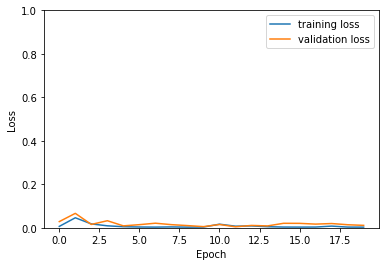

In [9]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=8, validation_split=0.2,verbose=1)

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [49]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

Binding Energy Per Nucleon:  -103.04091
Binding Energy:  -1648.654541015625


## Save the model for posterity

Since it takes a long time to train

In [109]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing.h5')
